In [1]:
cd /home/ubuntu/FedEM/

/home/ubuntu/FedEM


In [1]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from torch.utils.tensorboard import SummaryWriter
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *

from transfer_attacks.TA_utils import *
from transfer_attacks.Boundary_Transferer import *

In [2]:
# Manually set argument parameters
args_ = Args()
args_.experiment = "celeba"
args_.method = "FedAvg_adv"
args_.decentralized = False
args_.sampling_rate = 1.0
args_.input_dimension = None
args_.output_dimension = None
args_.n_learners= 1
args_.n_rounds = 10
args_.bz = 128
args_.local_steps = 1
args_.lr_lambda = 0
args_.lr =0.03
args_.lr_scheduler = 'multi_step'
args_.log_freq = 10
args_.device = 'cuda'
args_.optimizer = 'sgd'
args_.mu = 0
args_.communication_probability = 0.1
args_.q = 1
args_.locally_tune_clients = False
args_.seed = 1234
args_.verbose = 1
args_.save_path = 'weights/cifar/22_01_09_fedavg_n80_benign/'
args_.validation = False
args_.num_user = 40
args_.tune_steps = None

# Generate the dummy values here

In [3]:
exp_names = ['weights/celeba_client_count_fedavg/c5/',
             'weights/celeba_client_count_fedavg/c10/',
             'weights/celeba_client_count_fedavg/c20/',
             'weights/celeba_client_count_fedavg/c30/',
             'weights/celeba_client_count_fedavg/c40/']

train_item = 'train_client_weights.npy'

cc = [5,10,20,30,40]

In [4]:
# Inter Boundary Distance Metric
custom_batch_size = 500

exp_logs = {}
num_exp = len(exp_names)

for j in range(num_exp):
    
    aggregator, clients = dummy_aggregator(args_, num_user=cc[j])
    num_victims = cc[j]
    
    data_x = []
    data_y = []

    for i in range(len(clients)):
        daniloader = clients[i].test_iterator
        for (x,y,idx) in daniloader.dataset:
            data_x.append(x)
            data_y.append(torch.Tensor([y]))

    data_x = torch.stack(data_x)
    data_y = torch.stack(data_y)
    
    # Set Up Dictionaries -- list holds the adversary idx


    logs_adv = []

    for i in range(num_victims):
        adv_dict = {}
        adv_dict['orig_acc_transfers'] = None
        adv_dict['orig_similarities'] = None
        adv_dict['adv_acc_transfers'] = None
        adv_dict['adv_similarities_target'] = None
        adv_dict['adv_similarities_untarget'] = None
        adv_dict['adv_target'] = None
        adv_dict['adv_miss'] = None
        adv_dict['metric_alignment'] = None
        adv_dict['ib_distance_legit'] = None
        adv_dict['ib_distance_adv'] = None

        logs_adv += [adv_dict]

    exp_logs[j] = copy.deepcopy(logs_adv)

    
    
    print('processing file', exp_names[j], '...')
    
    # Change name if need be
    args_.save_path = exp_names[j]

    # Import weights for aggregator
    aggregator.load_state(args_.save_path)

    # This is where the models are stored -- one for each mixture --> learner.model for nn
    hypotheses = aggregator.global_learners_ensemble.learners

    # obtain the state dict for each of the weights 
    weights_h = []

    for h in hypotheses:
        weights_h += [h.model.state_dict()]
        
    weight_name = args_.save_path + train_item
    weights = np.load(weight_name)
    np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

    # Set model weights
    model_weights = []
    num_models = num_victims

    for i in range(num_models):
        model_weights += [weights[i]]


    # Generate the weights to test on as linear combinations of the model_weights
    models_test = []

    for (w0) in model_weights:
        # first make the model with empty weights
        new_model = copy.deepcopy(hypotheses[0].model)
        new_model.eval()
        new_weight_dict = copy.deepcopy(weights_h[0])
        for key in weights_h[0]:
            new_weight_dict[key] = w0[0]*weights_h[0][key] 
        new_model.load_state_dict(new_weight_dict)
        models_test += [new_model]
    

    victim_idxs = range(num_victims)

    for adv_idx in victim_idxs:
        print("\t Adv idx:", adv_idx)
        # Perform Attacks
        dataloader = load_client_data(clients = clients, c_id = adv_idx, mode = 'test') # or test/train
        batch_size = min(custom_batch_size, dataloader.y_data.shape[0])
        
        t1 = Transferer(models_list=models_test, dataloader=dataloader)
        t1.generate_victims(victim_idxs)
        
        t1.atk_params = PGD_Params()
        t1.atk_params.set_params(batch_size=batch_size, iteration = 10,
                       target = 8, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                       step_size = 0.01, step_norm = "inf", eps = 4.5, eps_norm = 2)

        t1.generate_advNN(adv_idx)
        t1.generate_xadv(atk_type = "pgd")
        t1.send_to_victims(victim_idxs)
        # t1.check_empirical_metrics(orig_flag = True)

        # Log Performance
        exp_logs[j][adv_idx]['orig_acc_transfers'] = copy.deepcopy(t1.orig_acc_transfers)
        exp_logs[j][adv_idx]['orig_similarities'] = copy.deepcopy(t1.orig_similarities)
        exp_logs[j][adv_idx]['adv_acc_transfers'] = copy.deepcopy(t1.adv_acc_transfers)
        exp_logs[j][adv_idx]['adv_similarities_target'] = copy.deepcopy(t1.adv_similarities)        
        exp_logs[j][adv_idx]['adv_target'] = copy.deepcopy(t1.adv_target_hit)

        # Miss attack
        t1.atk_params.set_params(batch_size=batch_size, iteration = 10,
                       target = -1, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                       step_size = 0.01, step_norm = "inf", eps = 4.5, eps_norm = 2)
        t1.generate_xadv(atk_type = "pgd")
        t1.send_to_victims(victim_idxs)
        exp_logs[j][adv_idx]['adv_miss'] = copy.deepcopy(t1.adv_acc_transfers)
        exp_logs[j][adv_idx]['adv_similarities_untarget'] = copy.deepcopy(t1.adv_similarities)


    del models_test

==> Clients initialization..
===> Building data iterators..


100%|████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 172.20it/s]


===> Initializing clients..


100%|█████████████████████████████████████████████████████████████████████████████| 80/80 [00:22<00:00,  3.59it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 3.331 | Train Acc: 2.107% |Test Loss: 3.319 | Test Acc: 2.632% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################
processing file weights/celeba_client_count_fedavg/c5/ ...
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
==> Clients initialization..
===> Building data iterators..


100%|████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 294.42it/s]


===> Initializing clients..


100%|█████████████████████████████████████████████████████████████████████████████| 80/80 [00:15<00:00,  5.16it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 3.301 | Train Acc: 2.102% |Test Loss: 3.298 | Test Acc: 2.258% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################
processing file weights/celeba_client_count_fedavg/c10/ ...
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
==> Clients initialization..
===> Building data iterators..


100%|████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 293.57it/s]


===> Initializing clients..


100%|█████████████████████████████████████████████████████████████████████████████| 80/80 [00:16<00:00,  4.98it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 3.328 | Train Acc: 2.099% |Test Loss: 3.330 | Test Acc: 2.121% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################
processing file weights/celeba_client_count_fedavg/c20/ ...
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
==> Clients initialization..
===> Building data iterators..


100%|████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 293.88it/s]


===> Initializing clients..


100%|█████████████████████████████████████████████████████████████████████████████| 80/80 [00:16<00:00,  4.94it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 3.328 | Train Acc: 2.275% |Test Loss: 3.322 | Test Acc: 2.096% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################
processing file weights/celeba_client_count_fedavg/c30/ ...
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 21
	 Adv idx: 22
	 Adv idx: 23
	 Adv idx: 24
	 Adv idx: 25
	 Adv idx: 26
	 Adv idx: 27
	 Adv idx: 28
	 Adv idx: 29
==> Clients initialization..
===> Building data iterators..


100%|████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 295.06it/s]


===> Initializing clients..


100%|█████████████████████████████████████████████████████████████████████████████| 80/80 [00:16<00:00,  4.96it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 3.321 | Train Acc: 2.317% |Test Loss: 3.320 | Test Acc: 2.036% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################
processing file weights/celeba_client_count_fedavg/c40/ ...
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 21
	 Adv idx: 22
	 Adv idx: 23
	 Adv idx: 24
	 Adv idx: 25
	 Adv idx: 26
	 Adv idx: 27
	 Adv idx: 28
	 Adv idx: 29
	 Adv idx: 30
	 Adv idx: 31
	 Adv idx: 32
	 Adv idx: 33
	 Adv idx: 34
	 Adv idx: 35
	 Adv idx: 36
	 Adv idx: 37
	 Adv idx: 38
	 Adv idx: 39


Organizing and plotting data

In [5]:
metrics = ['orig_acc_transfers','orig_similarities','adv_acc_transfers','adv_similarities_target',
           'adv_similarities_untarget','adv_target','adv_miss'] #,'metric_alignment']


orig_acc = []
orig_sim = []
adv_acc = []
adv_sim_target = []
adv_sim_untarget = []
adv_target = []
adv_miss = []

for i in range(len(exp_names)):
    victim_idxs = range(cc[i])
    
    orig_acc += [np.zeros([len(victim_idxs),len(victim_idxs)])]
    orig_sim += [np.zeros([len(victim_idxs),len(victim_idxs)])]
    adv_acc += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    adv_sim_target += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    adv_sim_untarget += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    adv_target += [np.zeros([len(victim_idxs),len(victim_idxs)])]
    adv_miss += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    
    for adv_idx in range(len(victim_idxs)):
        for victim in range(len(victim_idxs)):
            orig_acc[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[0]][victim_idxs[victim]].data.tolist()
            orig_sim[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[1]][victim_idxs[victim]].data.tolist()
            adv_acc[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[2]][victim_idxs[victim]].data.tolist()
            adv_sim_target[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[3]][victim_idxs[victim]].data.tolist()
            adv_sim_untarget[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[4]][victim_idxs[victim]].data.tolist()
            adv_target[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[5]][victim_idxs[victim]].data.tolist()
            adv_miss[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[6]][victim_idxs[victim]].data.tolist()

In [6]:
# Edit desired data

# FedEM
#y_acc [0.6760671377182007, 0.7136423587799072, 0.7372033357620239, 0.7761624693870545, 0.7849586471915245]
#y_robust [0.1777084108442068, 0.1776479081147247, 0.1338047871856313, 0.1338509052991867, 0.1789458606296625]
#y_target [0.7647183060646057, 0.5976678043603897, 0.538523785534658, 0.5905092922092854, 0.5262070793754016]

# FedAvg
# y_acc [0.7069079041481018, 0.7568677663803101, 0.7699355095624923, 0.7863007009029388, 0.7794541999697685]
# y_robust [0.13665961474180222, 0.10503610819578171, 0.1095440300181508, 0.08539326836665471, 0.1008506833575666]
# y_target [0.5958631038665771, 0.6664312899112701, 0.654417771100998, 0.6915753920873006, 0.6004716627299785]

x = [5,10,20,30,40]
# Acc
y_acc = []
y_robust = []
y_target = []
for i in range(len(exp_names)):
    y_acc += [np.mean(np.diagonal(orig_acc[i]))]
    y_robust += [avg_nondiag(adv_miss[i])]
    y_target += [avg_nondiag(adv_target[i])]
    
print('y_acc', y_acc)
print('y_robust', y_robust)
print('y_target', y_target)

y = [y_acc, y_robust, y_target]

y_acc [0.7069079041481018, 0.7568677663803101, 0.7699355095624923, 0.7863007009029388, 0.7794541999697685]
y_robust [0.13665961474180222, 0.10503610819578171, 0.1095440300181508, 0.08539326836665471, 0.1008506833575666]
y_target [0.5958631038665771, 0.6664312899112701, 0.654417771100998, 0.6915753920873006, 0.6004716627299785]


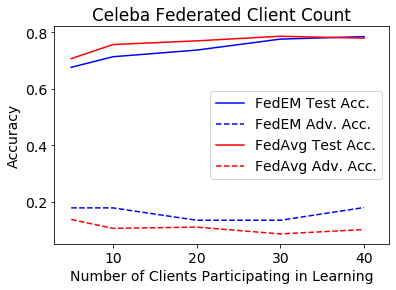

In [8]:
# FedEM

y_acc_em = [0.6760671377182007, 0.7136423587799072, 0.7372033357620239, 0.7761624693870545, 0.7849586471915245]
y_robust_em = [0.1777084108442068, 0.1776479081147247, 0.1338047871856313, 0.1338509052991867, 0.1789458606296625]
y_target_em = [0.7647183060646057, 0.5976678043603897, 0.538523785534658, 0.5905092922092854, 0.5262070793754016]

y_acc_av = [0.7069079041481018, 0.7568677663803101, 0.7699355095624923, 0.7863007009029388, 0.7794541999697685]
y_robust_av = [0.13665961474180222, 0.10503610819578171, 0.1095440300181508, 0.08539326836665471, 0.1008506833575666]
y_target_av = [0.5958631038665771, 0.6664312899112701, 0.654417771100998, 0.6915753920873006, 0.6004716627299785]


y1 = [y_acc_em, y_robust_em, y_target_em]
y2 = [y_acc_av, y_robust_av, y_target_av]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)


names1 = ['FedEM Test Acc.', 'FedEM Adv. Acc.']
names2 = ['FedAvg Test Acc.', 'FedAvg Adv. Acc.']
colors = ['b','r']
types = ['-', '--']


for i in range(len(names1)):
    plt.plot(x,y1[i],label= names1[i], linestyle = types[i], color = colors[0])
for i in range(len(names2)):
    plt.plot(x,y2[i],label= names2[i], linestyle = types[i], color = colors[1])
    
plt.legend(frameon=True)
plt.xlim(3, 43);
# plt.ylim(0, 1.0);
plt.xlabel('Number of Clients Participating in Learning')
plt.ylabel('Accuracy')
plt.title("Celeba Federated Client Count")
plt.savefig('Celeba_client_count.png')